In [ ]:
!pip install kaggle
!pip install nltk

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohammadhrajabig","key":"3c3e62e674fd8ffdcbdd534dc13e5462"}'}

In [ ]:
from datetime import datetime

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kaushiksuresh147/bitcoin-tweets


 98% 681M/695M [00:06<00:00, 115MB/s]
100% 695M/695M [00:06<00:00, 106MB/s]


In [ ]:
!unzip /content/bitcoin-tweets.zip

Archive:  /content/bitcoin-tweets.zip
  inflating: Bitcoin_tweets.csv      
  inflating: Bitcoin_tweets_dataset_2.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import TextClassificationPipeline, AutoModelForSequenceClassification, AutoTokenizer
from tqdm import tqdm
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
tqdm.pandas()

In [ ]:
df_clean = pd.read_csv('/content/Bitcoin_tweets.csv', lineterminator='\n')

<ipython-input-8-a993b4f5b016>:1: DtypeWarning: Columns (4,5,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean = pd.read_csv('/content/Bitcoin_tweets.csv', lineterminator='\n')


In [ ]:
price_df = pd.read_csv('/content/300-filtered.csv')
price_df["datetime"] = price_df["timestamp"].apply(lambda x: datetime.fromtimestamp(x))
price_df.drop(3888,inplace=True)
len(price_df)
price_df

,Unnamed: 0,timestamp,open,high,low,close,volume,trade,datetime
0,190416,1626523200,31377.01,31377.01,31330.12,31336.16,972.357,8043,2021-07-17 12:00:00
1,190417,1626523500,31336.16,31415.00,31333.00,31384.01,1149.290,8885,2021-07-17 12:05:00
2,190418,1626523800,31384.00,31428.37,31374.61,31410.99,774.196,7632,2021-07-17 12:10:00
3,190419,1626524100,31410.99,31450.00,31403.97,31406.16,838.528,8416,2021-07-17 12:15:00
4,190420,1626524400,31406.17,31454.70,31404.00,31450.43,950.116,7677,2021-07-17 12:20:00
...,...,...,...,...,...,...,...,...,...
3883,194299,1627688100,41607.06,41750.00,41555.67,41576.98,3796.460,35545,2021-07-30 23:35:00
3884,194300,1627688400,41576.98,41922.00,41576.62,41877.19,3235.068,27673,2021-07-30 23:40:00
3885,194301,1627688700,41877.19,42000.00,41575.01,41922.64,8699.166,69932,2021-07-30 23:45:00
3886,194302,1627689000,41919.60,42245.00,41785.00,42111.48,9801.120,73416,2021-07-30 23:50:00


In [ ]:
df = df_clean.copy()
df

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4689349,TAnotepad,Not financial advice,#Bitcoin | Forever Alone Crypto Trader 😭 | Ana...,2022-11-04 10:18:11,674,1789,27466,False,2023-01-06 17:46:35,"Bitcoin squeeze is SUPER TIGHT, which way will...","['BTC', 'bitcoin', 'Crypto', 'cryptocurrency',...",Twitter for Android,False
4689350,Boba-Feh,South of the North Pole,My backpack has jets. Reformed Necromonger,2008-04-02 21:48:47,79,454,125,False,2023-01-06 17:46:29,Closed #BTC short at 16725. Missed my long pla...,['BTC'],Twitter for Android,False
4689351,Ethereum Yoda,NaN,UP or DOWN...\n.\n.\n.\n.\nPrice matters NOT.,2022-07-24 04:50:18,532,1,0,False,2023-01-06 17:46:22,#Ethereum price update: \n\n#ETH $1263.59 USD\...,"['Ethereum', 'ETH', 'Bitcoin', 'BTC', 'altcoin...",Twitter Web App,False
4689352,Bitcoin Price Ticker,NaN,Tweets the current price of #bitcoin every 5 m...,2022-10-20 07:10:38,83,7,9,False,2023-01-06 17:46:20,1₿ = $16814.7 -0.07%🔻\n\nDetails:\nChange: 🔻-1...,"['bitcoin', 'btc']",BitcoinLivePriceTicker,False


In [ ]:
# timestamps = []
# for datetime_str in df['date']:
#     try:
#         timestamp = pd.to_datetime(datetime_str)
#     except ValueError:
#         print(f"Invalid datetime string: {datetime_str}")
#         timestamp = pd.NaT
#     timestamps.append(timestamp)

# # Add the timestamps to the DataFrame
# df['date'] = timestamps
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [ ]:
df.dropna(subset=['date'], inplace=True)

In [ ]:
sorted_df = df.sort_values(by='date')

In [ ]:
sorted_df

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
21523,Iconic Holding,"Frankfurt am Main, Germany",Professional Crypto Asset Ventures \nhttps://t...,2021-01-05 13:22:24,301.0,1075,361,False,2021-02-05 10:52:04,2⃣ Debunking 9 #Bitcoin Myths by @Patrick_Lo...,"['Bitcoin', 'cryptocurrency', 'bitcoin', 'cryp...",Twitter Web App,False
21524,Iconic Holding,"Frankfurt am Main, Germany",Professional Crypto Asset Ventures \nhttps://t...,2021-01-05 13:22:24,301.0,1075,361,False,2021-02-05 10:52:04,📖 Weekend Read 📖\n\nKeen to learn about #cryp...,['crypto'],Twitter Web App,False
21522,Iconic Holding,"Frankfurt am Main, Germany",Professional Crypto Asset Ventures \nhttps://t...,2021-01-05 13:22:24,301.0,1075,361,False,2021-02-05 10:52:06,4⃣ 🎙️ Bloomberg LP #CryptoOutlook 2021 with @...,"['CryptoOutlook', 'cryptocurrency', 'bitcoin',...",Twitter Web App,False
21521,Iconic Holding,"Frankfurt am Main, Germany",Professional Crypto Asset Ventures \nhttps://t...,2021-01-05 13:22:24,301.0,1075,361,False,2021-02-05 10:52:07,"5⃣ #Blockchain 50 2021 by @DelRayMan, @Forbe...","['Blockchain', 'cryptocurrency', 'bitcoin', 'c...",Twitter Web App,False
21520,Nick Doevendans,"Edam-Volendam, Nederland","Amateur historicus m.n. WW2, schrijver, muziek...",2020-06-12 16:50:07,37.0,123,410,False,2021-02-05 10:52:26,#reddcoin #rdd @reddcoin to the moon #altcoin ...,"['reddcoin', 'rdd', 'altcoin', 'turnreddcoinin...",Twitter for iPhone,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4628469,BNB Price Tracker,NaN,#BNB #BNBTracker #BinanceCoin #Binance,2022-07-11 05:24:30,418,5,0,False,2023-01-09 23:59:33,#BinanceCoin price update: $BNB\n\n#BNB $272.6...,"['BinanceCoin', 'BNB', 'Bitcoin', 'Ethereum', ...",Twitter Web App,False
4628468,Pepe_,NaN,"Interested in the link between technology, cul...",2014-07-20 04:10:33,165,138,4,False,2023-01-09 23:59:36,#bitcoin maxis are upset #PiNetwork is trendin...,"['bitcoin', 'PiNetwork']",Twitter Web App,False
4644940,rete23142,NaN,NaN,2022-04-19 07:54:37,1,2,0,False,2023-01-09 23:59:39,We're only going to be released for a few days...,"['btc', 'BTC', 'XRP', 'ETH', 'ADA', 'LUNA', 'S...","Cheap Bots, Done Quick!",False
4628467,Donna cryptotradingpro📊,United States,Bitcoin/FX Trade Expert 📊 and professional cry...,2021-11-13 22:17:03,752,720,1315,False,2023-01-09 23:59:46,BECAUSE IT'S A LIFE\nCHANGING\nOPPORTUNITY FOR...,"['twitchstreamer', 'Bitcoin', 'XboxGamePass', ...",Twitter for iPhone,False


In [ ]:
start_date = '2021-07-17 12:00:00'
end_date = '2021-07-30'
sorted_df.set_index('date', inplace=True)
sliced_df = sorted_df.loc[start_date:end_date]


In [ ]:
minimal_df = sliced_df[['text']]

In [ ]:
minimal_df

,text
date,
2021-07-17 12:00:00,"Baller, Jack Mallers Calls Out Brian Armstrong..."
2021-07-17 12:00:00,Square developing #bitcoin-focused business as...
2021-07-17 12:00:00,#Bitcoin\nCurrent Price:\n$ 31397.97\n€ 26640....
2021-07-17 12:00:00,Now tell me looking straight into my eyes that...
2021-07-17 12:00:00,There are a number of walk-in NHS vaccination ...
...,...
2021-07-30 23:59:56,@HodlingCarla Wooohoooo 200k in sight #bitcoin...
2021-07-30 23:59:56,"Before you know it we'll be under 90,000,000,0..."
2021-07-30 23:59:57,#btc just hit Jackie Robinson


In [ ]:
# model_name = "ElKulako/cryptobert"
# tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 3)
# pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, max_length=64, truncation=True, padding = 'max_length')



In [ ]:
def add_label(row):
    # Example function, you can replace this with your own function
    return pipe(row.text)[0]['label']

In [ ]:
def add_score(row):
    # Example function, you can replace this with your own function
    return pipe(row.text)[0]['score']

In [ ]:
sliced_df['Label'] = sliced_df.progress_apply(add_label , axis=1)
sliced_df['score'] = sliced_df.progress_apply(add_score , axis=1)

In [ ]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
minimal_df['sentiment'] = minimal_df['text'].progress_apply(lambda text: sia.polarity_scores(text)['compound'])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████| 369626/369626 [01:45<00:00, 3492.83it/s]
<ipython-input-64-4f25154f020b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minimal_df['sentiment'] = minimal_df['text'].progress_apply(lambda text: sia.polarity_scores(text)['compound'])


In [ ]:
# minimal_df = minimal_df[~minimal_df.index.duplicated(keep='first')]
minimal_df

,text,sentiment
date,,
2021-07-17 12:00:00,"Baller, Jack Mallers Calls Out Brian Armstrong...",0.0000
2021-07-17 12:00:00,Square developing #bitcoin-focused business as...,0.0000
2021-07-17 12:00:00,#Bitcoin\nCurrent Price:\n$ 31397.97\n€ 26640....,0.0000
2021-07-17 12:00:00,Now tell me looking straight into my eyes that...,-0.0516
2021-07-17 12:00:00,There are a number of walk-in NHS vaccination ...,0.0772
...,...,...
2021-07-30 23:59:56,@HodlingCarla Wooohoooo 200k in sight #bitcoin...,0.0000
2021-07-30 23:59:56,"Before you know it we'll be under 90,000,000,0...",0.0000
2021-07-30 23:59:57,#btc just hit Jackie Robinson,0.0000


In [ ]:
grouped_df = minimal_df.resample('5T').agg({'sentiment': ['count', 'mean']})
grouped_df.columns = ['count_of_tweets', 'average_CompoundValue']
grouped_df

,count_of_tweets,average_CompoundValue
date,,
2021-07-17 12:00:00,132,0.193783
2021-07-17 12:05:00,73,0.221316
2021-07-17 12:10:00,96,0.158877
2021-07-17 12:15:00,80,0.153381
2021-07-17 12:20:00,83,0.185848
...,...,...
2021-07-30 23:35:00,133,0.184417
2021-07-30 23:40:00,141,0.260830
2021-07-30 23:45:00,145,0.188428


In [ ]:
price_df.set_index('datetime', inplace=True)
price_df

,Unnamed: 0,timestamp,open,high,low,close,volume,trade
datetime,,,,,,,,
2021-07-17 12:00:00,190416,1626523200,31377.01,31377.01,31330.12,31336.16,972.357,8043
2021-07-17 12:05:00,190417,1626523500,31336.16,31415.00,31333.00,31384.01,1149.290,8885
2021-07-17 12:10:00,190418,1626523800,31384.00,31428.37,31374.61,31410.99,774.196,7632
2021-07-17 12:15:00,190419,1626524100,31410.99,31450.00,31403.97,31406.16,838.528,8416
2021-07-17 12:20:00,190420,1626524400,31406.17,31454.70,31404.00,31450.43,950.116,7677
...,...,...,...,...,...,...,...,...
2021-07-30 23:35:00,194299,1627688100,41607.06,41750.00,41555.67,41576.98,3796.460,35545
2021-07-30 23:40:00,194300,1627688400,41576.98,41922.00,41576.62,41877.19,3235.068,27673
2021-07-30 23:45:00,194301,1627688700,41877.19,42000.00,41575.01,41922.64,8699.166,69932


Text(0.5, 1.0, 'Plot of closed price')

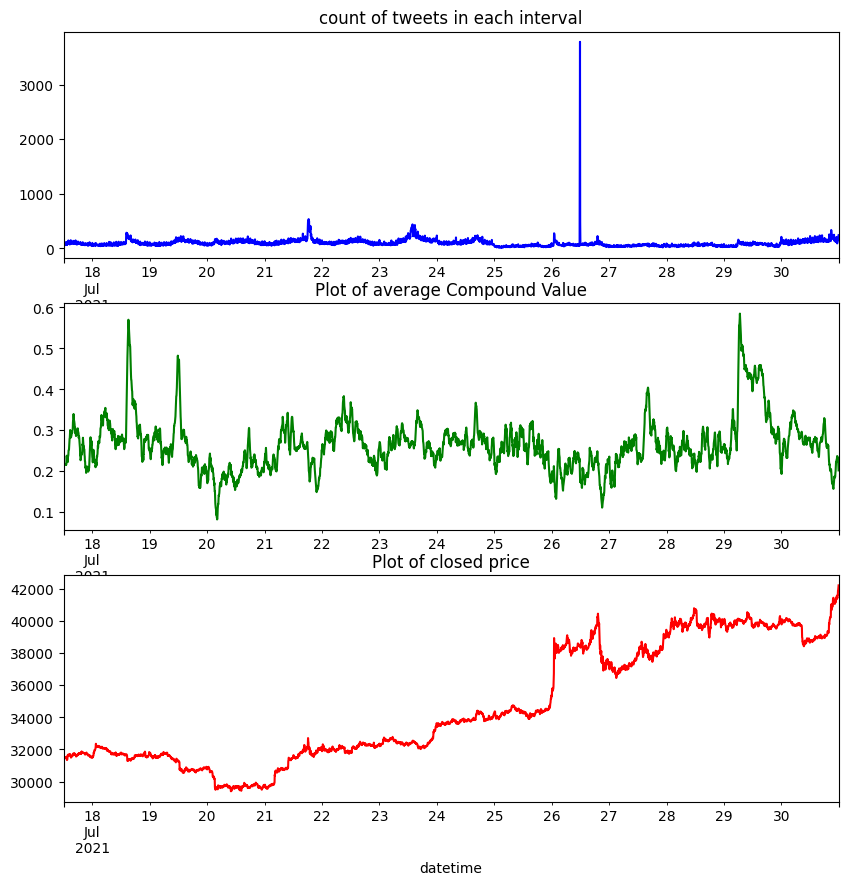

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))  # 2 rows, 1 column

# Plot each column in a separate subplot
grouped_df['count_of_tweets'].plot(ax=axs[0], color='blue', linestyle='-')
grouped_df['average_CompoundValue'].rolling(window=12).mean().plot(ax=axs[1], color='green', linestyle='-')
price_df['close'].plot(ax=axs[2], color='red', linestyle='-')
axs[0].set_title('count of tweets in each interval')
axs[1].set_title('Plot of average Compound Value')
axs[2].set_title('Plot of closed price')